4422102/4422102 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


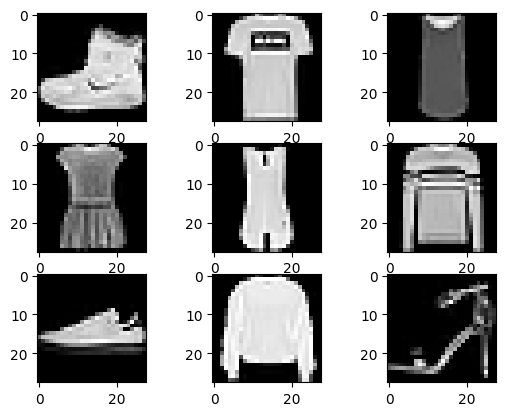

In [1]:
from matplotlib import pyplot
from keras.datasets import fashion_mnist
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

Data preprocessing


In [2]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

To plot diagnostics

In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

To run our code

In [4]:

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# Baseline Model

> 89.383
> 91.533
> 91.542
> 91.100
> 90.533


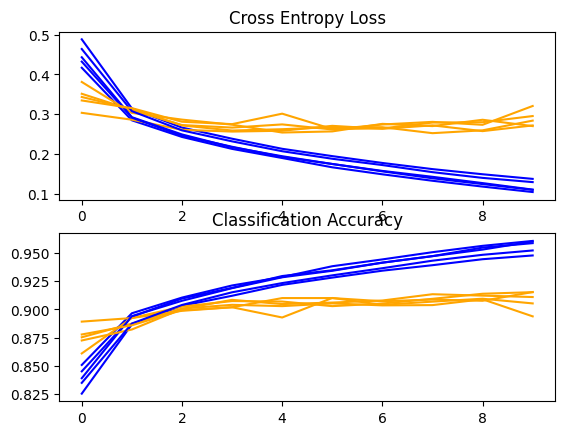

Accuracy: mean=90.818 std=0.807, n=5


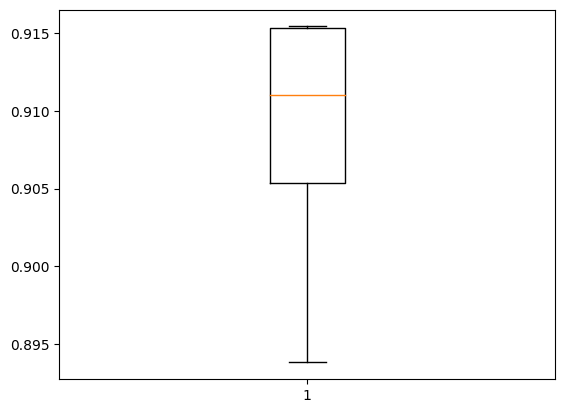

In [6]:

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

# Developing improved models

# 1. Padding Convolutions
Adding padding to the convolutional operation can often result in better model performance, as more of the input image of feature maps are given an opportunity to participate or contribute to the output

By default, the convolutional operation uses ‘valid‘ padding, which means that convolutions are only applied where possible. This can be changed to ‘same‘ padding so that zero values are added around the input such that the output has the same size as the input.

> 90.758
> 91.142
> 90.800
> 91.475
> 91.000


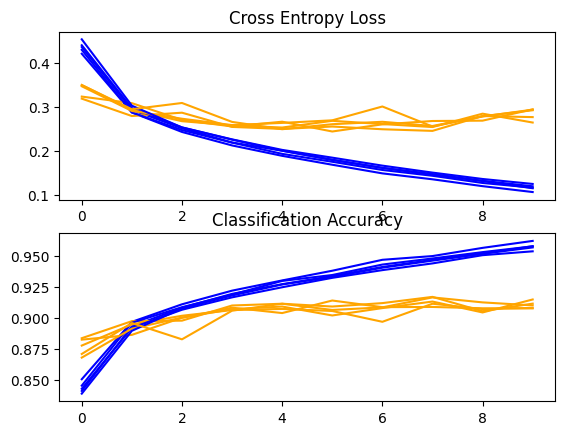

Accuracy: mean=91.035 std=0.260, n=5


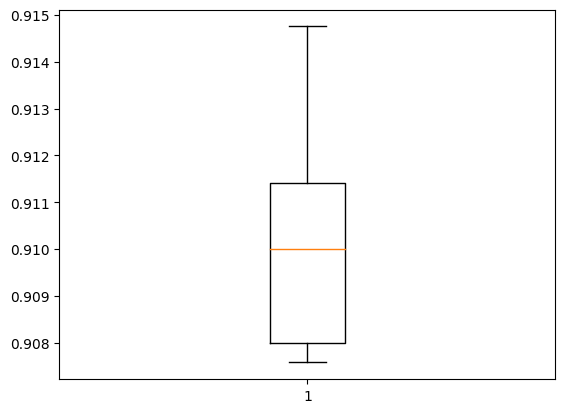

In [7]:

# define cnn model
def define_model():
	model = Sequential()
  #adding padding
	model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# entry point, run the test harness
run_test_harness()

# 2. Increasing Filters
An increase in the number of filters used in the convolutional layer can often improve performance, as it can provide more opportunity for extracting simple features from the input images.

This is especially relevant when very small filters are used, such as 3×3 pixels.

In this change, we can increase the number of filters in the convolutional layer from 32 to double that at 64. We will also build upon the possible improvement offered by using ‘same‘ padding.

> 91.417
> 90.767
> 91.200
> 90.992
> 91.167


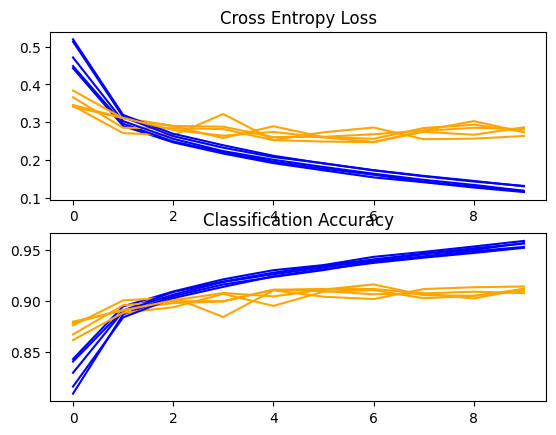

Accuracy: mean=91.108 std=0.218, n=5


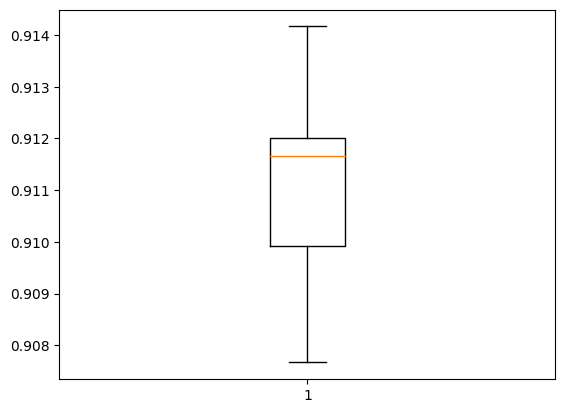

In [8]:
# define cnn model with increased filters
def define_model():
	model = Sequential()
  #adding padding
	model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# entry point, run the test harness
run_test_harness()

 the models still have a reasonable fit on the problem, with a small sign of some of the runs overfitting.

Padding with 32 layers did better than increasing filters did. Lets experiment some more

# 3. Additional Convolutional and Pooling Layers

4422102/4422102 [==============================] - 0s 0us/step


> 92.067


> 92.708


> 91.825


> 92.333
> 91.883


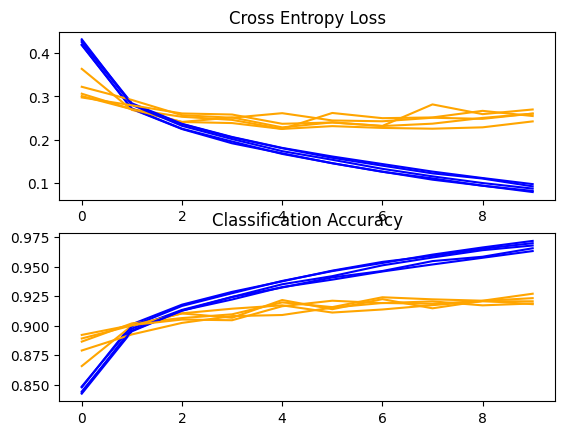

Accuracy: mean=92.163 std=0.325, n=5


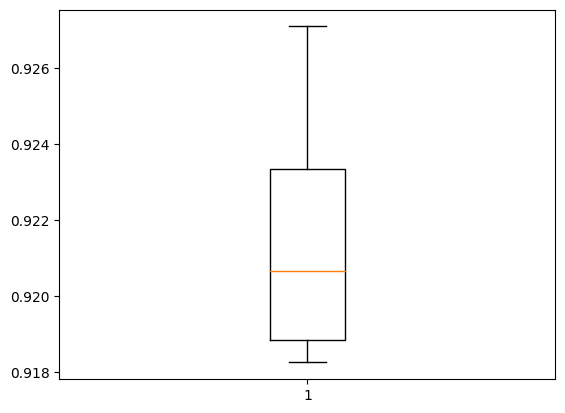

In [ ]:
#we have added more layers and test the model now
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# entry point, run the test harness
run_test_harness()

> 91.108
> 91.500
> 91.483
> 91.750
> 91.700


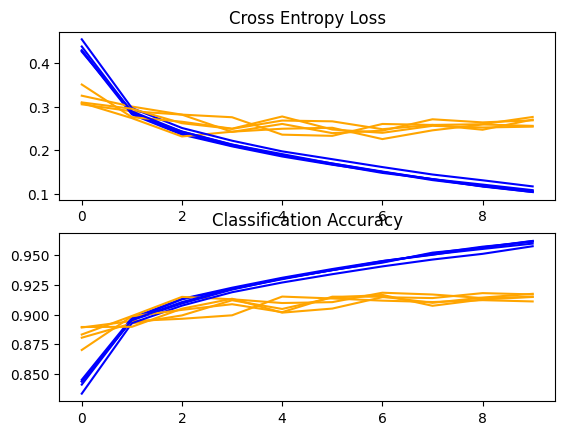

Accuracy: mean=91.508 std=0.226, n=5


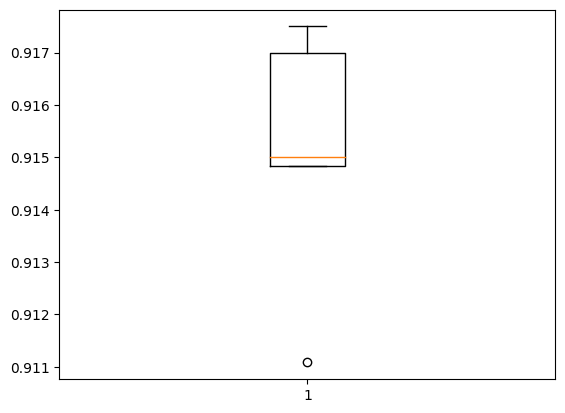

In [24]:
#we have added more layers and test the model now


# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories



# entry point, run the test harness
run_test_harness()

the mean accuracy is better in this case

# 4. Multiple Convolutional and Pooling Layers Sequentially

Each convolutional layer is followed by a max pooling layer, and this sequence is repeated, creating a deeper network architecture.

The intention behind this architecture is to allow the model to learn hierarchical features from the input images. Early layers might learn simple features like edges, while deeper layers might learn more complex patterns or textures present in the images.

> 88.517


> 88.792


> 88.458


> 88.992
> 87.317


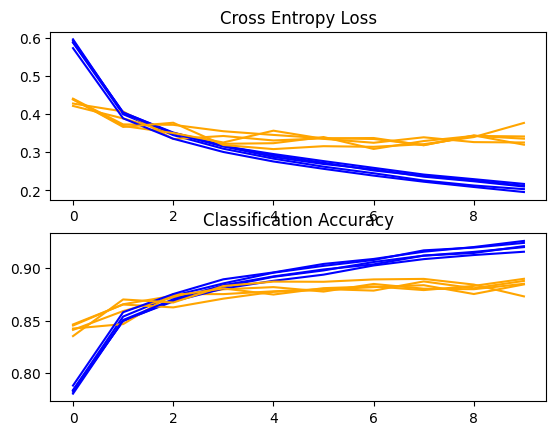

Accuracy: mean=88.415 std=0.582, n=5


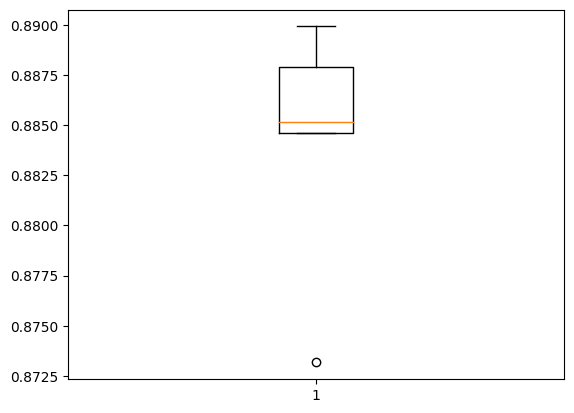

In [6]:
#we have added multiple convolutional and max pooling layers to create a deeper architecture and will test the model now
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# entry point, run the test harness
run_test_harness()

The mean accuracy rate of this model is the lowest so far

We add one more layer to make the architecture deeper and try again keeping everything same

> 91.242
> 91.817
> 91.492
> 91.133
> 91.158


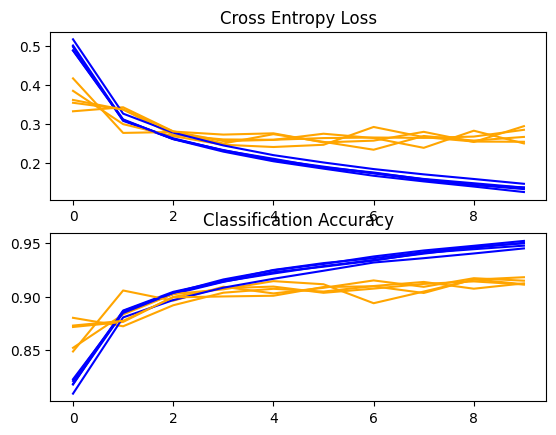

Accuracy: mean=91.368 std=0.258, n=5


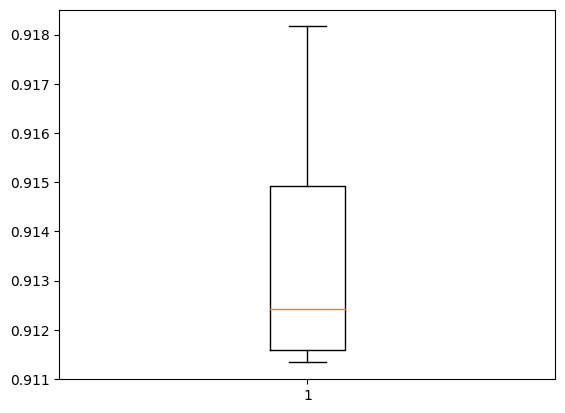

In [7]:
#we have added 4 convolutional and max pooling layers to create a deeper architecture and will test the model now

# define cnn model with 4 layers
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# entry point, run the test harness
run_test_harness()

#  5.  Regularization

## 5.1  Applying dropout


Adding dropout layers to the model helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training time, which helps to prevent overfitting.

> 90.692


> 90.500


> 90.933


> 90.933
> 91.742


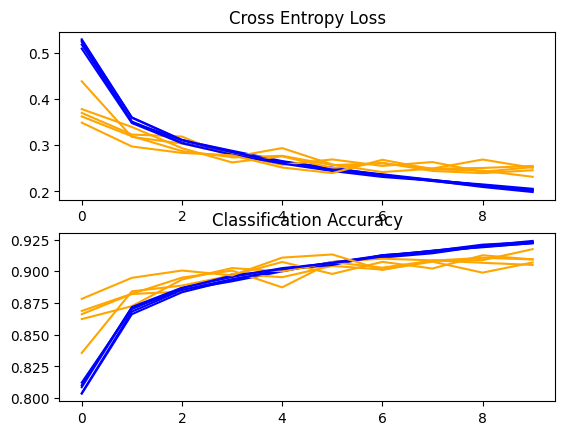

Accuracy: mean=90.960 std=0.423, n=5


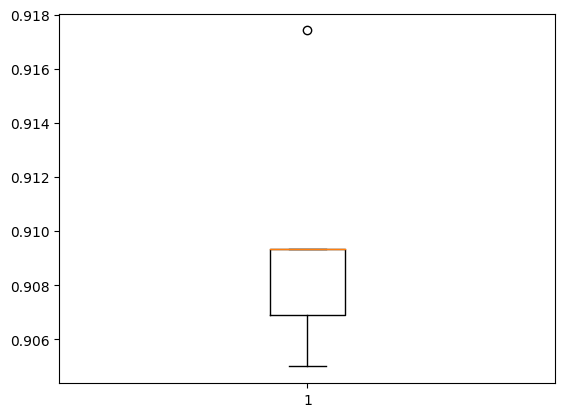

In [8]:
from keras.layers import Dropout

# define cnn model. We have applied dropout to each layer to avoid overfitting
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) #dropout rate of 20%
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# entry point, run the test harness
run_test_harness()

From the graphs, we can see that the test and train is converging. This could be because:

 1. **Good Generalization**
   - The model performs similarly on both the training and test datasets.

2. **Underfitting**

3.  **Plateauing**
   - Performance metrics remain constant over several epochs, indicating a plateau.Might need to change learning rate



Lets try changing the learning rate to 0.001

> 90.925


> 91.167
> 90.042


> 91.367
> 90.175


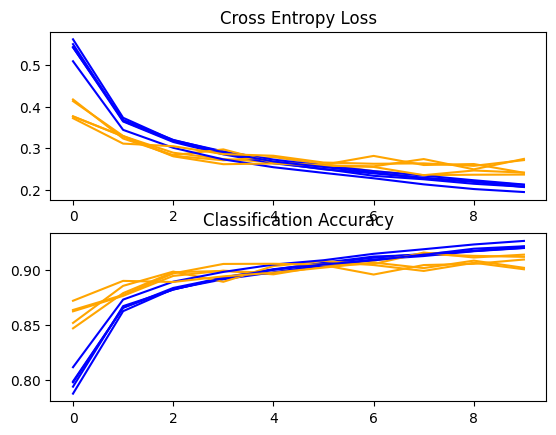

Accuracy: mean=90.735 std=0.532, n=5


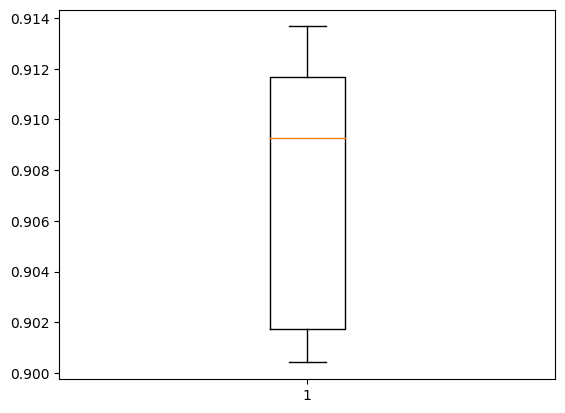

In [9]:
from keras.layers import Dropout

# define cnn model. We have applied dropout to each layer to avoid overfitting
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) #dropout rate of 20%
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# entry point, run the test harness
run_test_harness()

Mean accuracy was higher with learning rate of 0.01 so we stick to that for now

## 5.2 Early stopping + Dropout

we implement an early stopping with patience=3

> 90.225
> 91.408
> 91.800
> 91.125
> 90.992


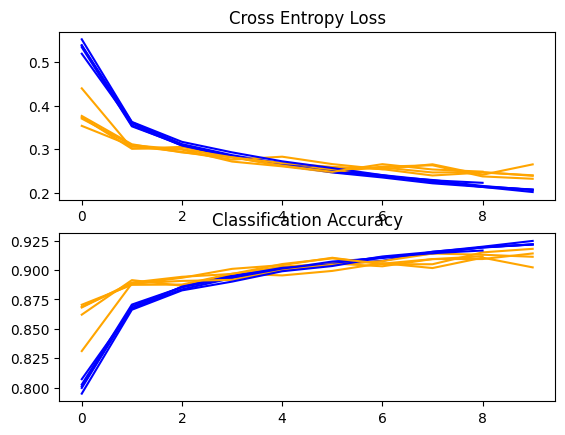

Accuracy: mean=91.110 std=0.522, n=5


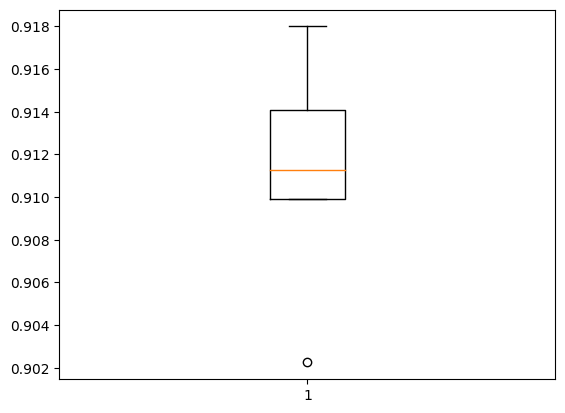

In [11]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

# define cnn model. We have applied dropout to each layer to avoid overfitting
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) #dropout rate of 20%
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), callbacks=[early_stopping],verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# entry point, run the test harness
run_test_harness()

We observe that our model performs better now. It is more robust.

The 6.2 Early stopping+Dropout model has shown an improvement over the baseline in terms of mean accuracy and consistency (lower standard deviation).

## 5.3 Batch normalizatiion

Applying to model 3

> 91.025
> 92.208
> 92.058
> 91.808
> 91.600


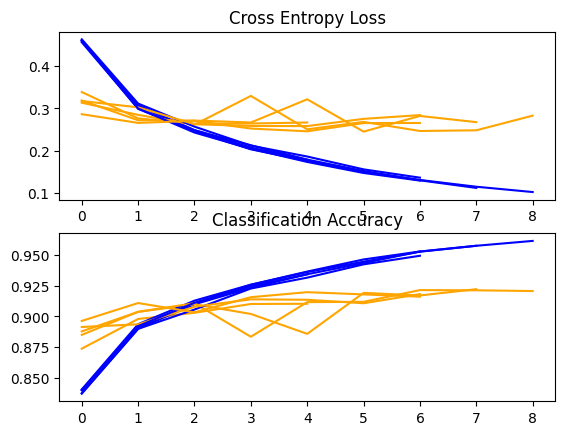

Accuracy: mean=91.740 std=0.414, n=5


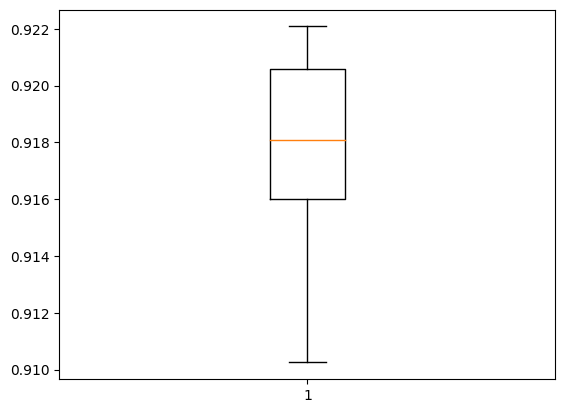

In [12]:

from keras.layers import BatchNormalization


#model 3(model with highest mean accuracy so far) with batch normalization and dropout
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())  # Batch normalization layer

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())  # Batch normalization layer

    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))  # Dropout layer with 50% dropout rate
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the EarlyStopping callback outside the loop
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0, callbacks=[early_stopping])
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


# entry point, run the test harness
run_test_harness()

Pretty good. Standard deviation is lower so model's variability in classification is lesser

We also want to try it on the 4 layer cnn to test if we can use a deeper neural network

# 6. Hyperparameter Tuning


We perform hyperparameter tuning to find the optimal parameters -> number of epochs, batch size learning rate

1. First we install scikeras scikit-learn package


In [ ]:
pip install tensorflow scikeras scikit-learn


2. Find best parameters

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# Define the model function
def define_model(learn_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=learn_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    return model

# Load and preprocess the dataset
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)

# Wrap the model with KerasClassifier
model = KerasClassifier(model=define_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'model__learn_rate': [0.01, 0.001],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(trainX, trainY)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


4422102/4422102 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.918883 using {'batch_size': 64, 'epochs': 20, 'model__learn_rate': 0.01}
0.914783 (0.001190) with: {'batch_size': 32, 'epochs': 10, 'model__learn_rate': 0.01}
0.907283 (0.004633) with: {'batch_size': 32, 'epochs': 10, 'model__learn_rate': 0.001}
0.915467 (0.002366) with: {'batch_size': 32, 'epochs': 20, 'model__learn_rate': 0.01}
0.907700 (0.003197) with: {'batch_size': 32, 'epochs': 20, 'model__learn_rate': 0.001}
0.916750 (0.006560) with: {'batch_size': 32, 'epochs': 30, 'model__learn_rate': 0.01}
0.910600 (0.001736) with: {'batch_size': 32, 'epochs': 30, 'model__learn_rate': 0.001}
0.916700 (0.001059) with: {'batch_size': 64, 'epochs': 10, 'model__learn_rate': 0.01}
0.904250 (0.002596) with: {'batch_size': 64, 'epochs': 10, 'model__learn_rate': 0.001}
0.918883 (0.001391) with: {'batch_size': 64, 'epochs': 20, 'model__learn_rate': 0.01}
0.905117 (0.002655) with: {'batch_size': 64, 'epochs': 20, 'model__learn_rate': 0.001}
0.917867 (0.001360) with: {'batch_size': 64, 'epochs':

Now that we have got the optimal parameters we train this model. Lets see if we will need early stopping for this

## 6.1 4 Layer CNN with optimal parameters

> Accuracy: 92.517
> Accuracy: 92.150
> Accuracy: 92.075
> Accuracy: 91.833
> Accuracy: 91.775


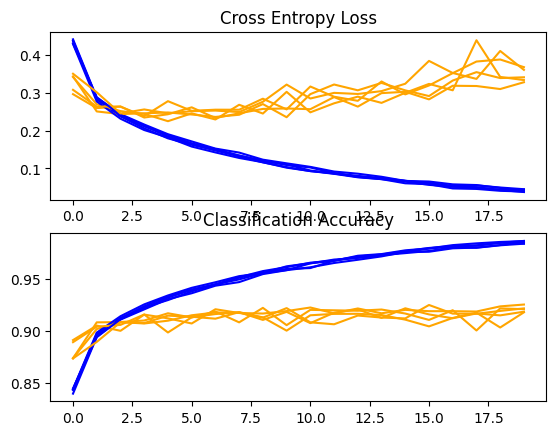

Accuracy: mean=92.070 std=0.264, n=5


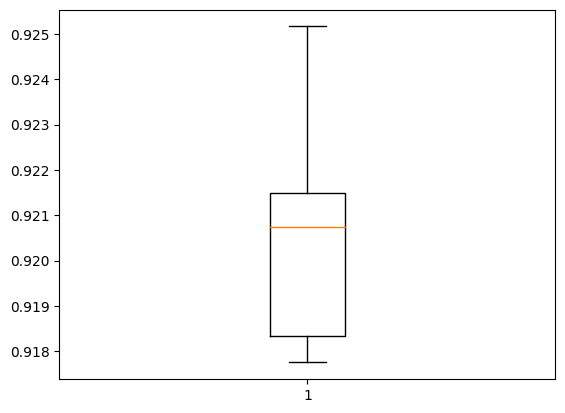

In [13]:

from keras.callbacks import EarlyStopping


# model with 4 convolutional and max pooling layers
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model with 20 epochs
        history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc, = model.evaluate(testX, testY, verbose=0)
        print('> Accuracy: %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories


# entry point, run the test harness
run_test_harness()



We see that the model has done very well and comparable to very simpler models with lesser training time

# 7. Deformed convolutions

First we implement our deformed layer. We have stuck with simpler approach

In [14]:
import tensorflow as tf
from keras.layers import Layer, Conv2D

class SimpleDeformableConvLayer(Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', activation=None, kernel_initializer='glorot_uniform', **kwargs):
        super(SimpleDeformableConvLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

        # Standard convolution layer
        self.conv_layer = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation, kernel_initializer=kernel_initializer)

        # Offset layer to apply the offsets to the conv. layer to learn and adapt
        self.offset_layer = Conv2D(filters=2 * kernel_size[0] * kernel_size[1],
                                   kernel_size=kernel_size,
                                   strides=strides,
                                   padding=padding,
                                   kernel_initializer='zeros')

    def call(self, inputs):
        # Calculate offsets
        offsets = self.offset_layer(inputs)
        # Applying offsets
        deformed_inputs = inputs + offsets
        # Perform standard convolution on deformed inputs
        x = self.conv_layer(deformed_inputs) # output stored in x
        # Apply activation function
        if self.activation is not None:
            x = self.activation(x)

        return x


## 7.1 1 DCN + 2 Conv

> 90.683
> 91.025
> 90.842
> 90.858
> 91.400


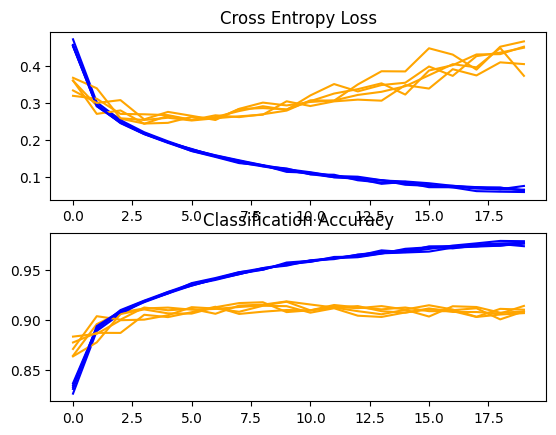

Accuracy: mean=90.962 std=0.244, n=5


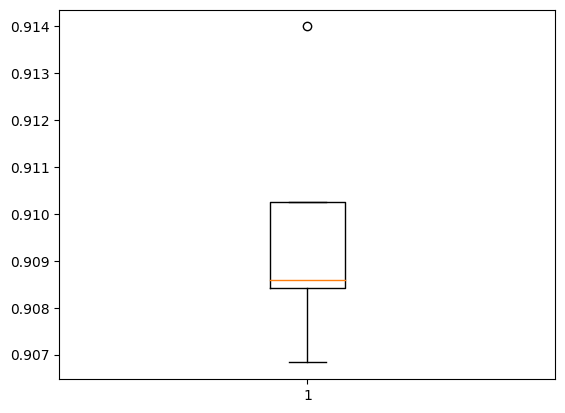

In [15]:
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import KFold


# Function to define the CNN model
def define_model():
    model = tf.keras.Sequential()
    model.add(SimpleDeformableConvLayer(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories


# entry point, run the test harness
run_test_harness()


## 7.2 1 DCN+3 Conv

We apply it to our 6.1 model with regularization and optimal parameters

> 91.858
> 89.575
> 92.108
> 91.850
> 91.925


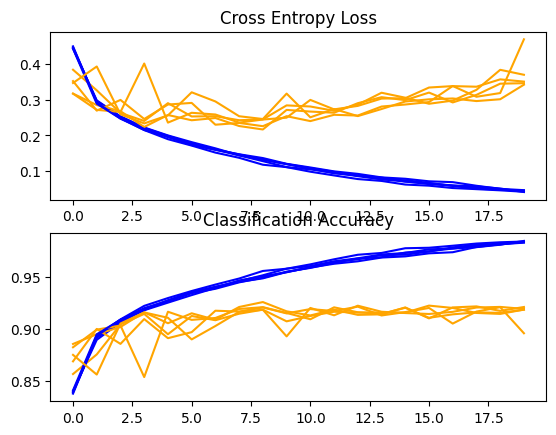

Accuracy: mean=91.463 std=0.949, n=5


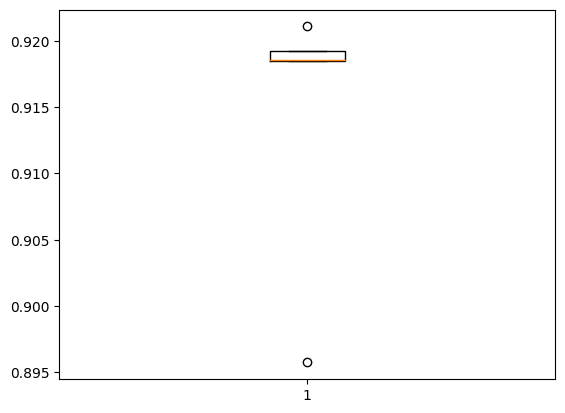

In [16]:

# Function to define the CNN model
def define_model():
    model = Sequential()
    model.add(SimpleDeformableConvLayer(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories


# entry point, run the test harness
run_test_harness()


We see that deformed convolutions don't help improve accuracies that much. This could be because our implementation is not complex

# 8. MixUp

In [17]:
from sklearn.utils import shuffle
def mixup_data(data, labels, alpha=0.2):
    num_samples, num_classes = labels.shape
    l = np.random.beta(alpha, alpha, num_samples)
    l = np.maximum(l, 1 - l)
    X_l = l[:, np.newaxis, np.newaxis, np.newaxis]
    y_l = l[:, np.newaxis]

    # Perform MixUp
    mixed_data = X_l * data + (1 - X_l) * data[::-1]
    mixed_labels = y_l * labels + (1 - y_l) * labels[::-1]

    return mixed_data, mixed_labels

4422102/4422102 [==============================] - 0s 0us/step


> 92.000


> 92.158


> 92.125


> 92.767
> 92.050


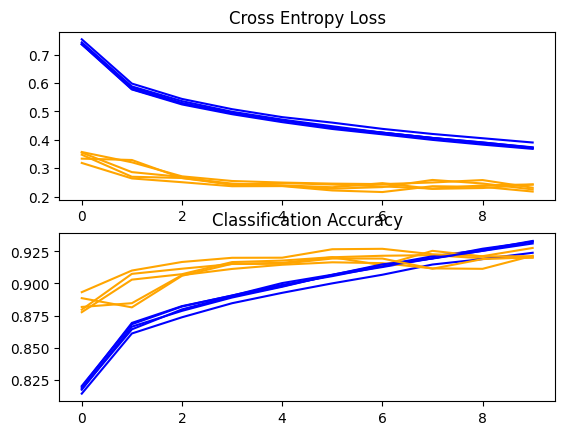

Accuracy: mean=92.220 std=0.279, n=5


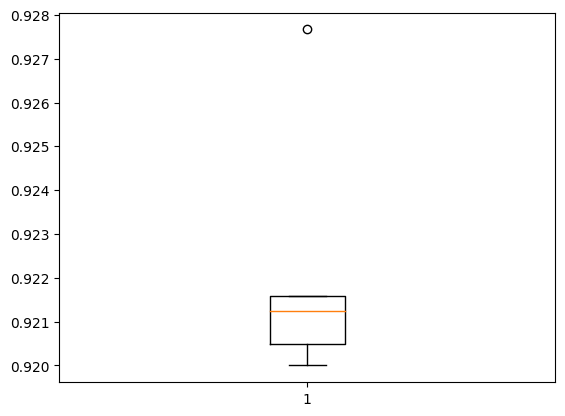

In [ ]:
# baseline cnn model for fashion mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import numpy as np
from sklearn.utils import shuffle

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    # Shuffle the training data
    trainX, trainY = shuffle(trainX, trainY, random_state=42)

    return trainX, trainY, testX, testY


# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def mixup_data(data, labels, alpha=0.2):
    num_samples, num_classes = labels.shape
    l = np.random.beta(alpha, alpha, num_samples)
    l = np.maximum(l, 1 - l)
    X_l = l[:, np.newaxis, np.newaxis, np.newaxis]
    y_l = l[:, np.newaxis]

    # Perform MixUp
    mixed_data = X_l * data + (1 - X_l) * data[::-1]
    mixed_labels = y_l * labels + (1 - y_l) * labels[::-1]

    return mixed_data, mixed_labels


# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    # Add the alpha value for MixUp augmentation
    alpha = 0.2

    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # Apply MixUp augmentation to the training data
        trainX, trainY = mixup_data(trainX, trainY, alpha)

        #Rest of Training Loop...

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

    return scores, histories


## 8.1 3 Conv + 3 Pool +  2 Dense

> 91.717


> 91.583


> 92.375


> 91.708
> 91.967


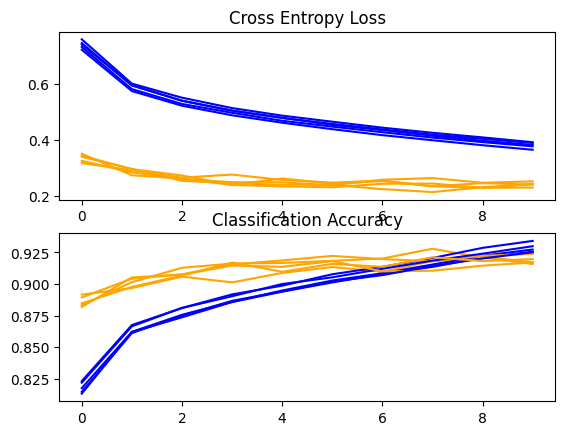

Accuracy: mean=91.870 std=0.281, n=5


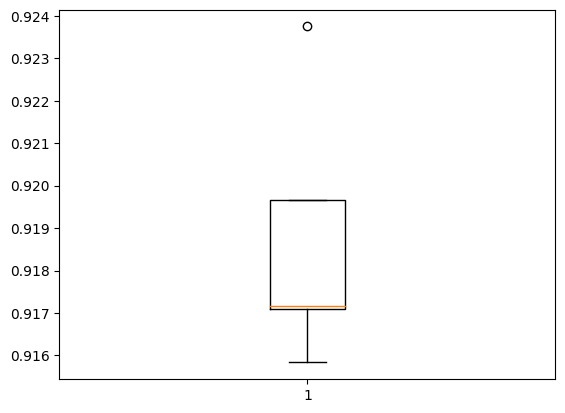

In [19]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# entry point, run the test harness
run_test_harness()

## 8.2 2 Conv + 2 Pool + 2 Dense

> 92.042


> 92.100


> 91.950


> 92.142
> 91.892


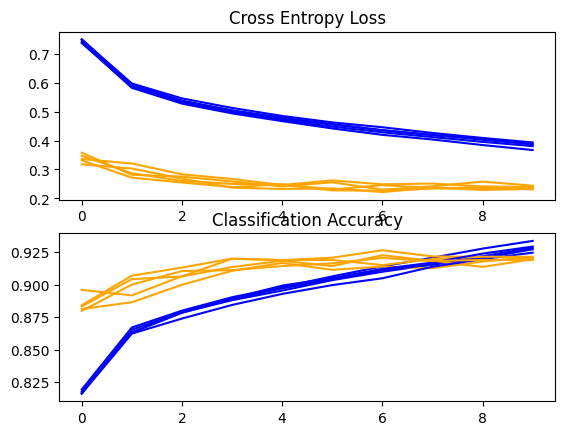

Accuracy: mean=92.025 std=0.093, n=5


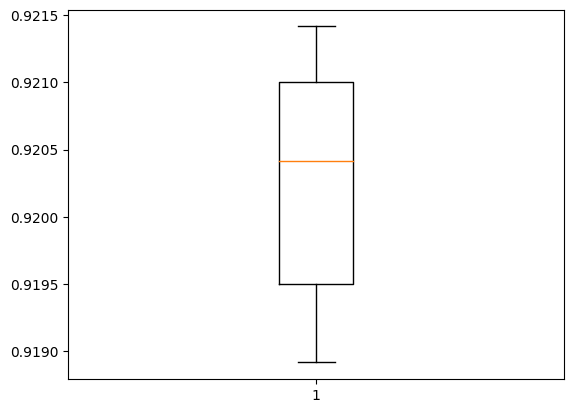

In [26]:


# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    # Add the alpha value for MixUp augmentation
    alpha = 0.2

    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # Apply MixUp augmentation to the training data
        trainX, trainY = mixup_data(trainX, trainY, alpha)

        #Rest of Training Loop...

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

    return scores, histories



# entry point, run the test harness
run_test_harness()

## 8.3 4 Layer CNN with optimal parameters

> 92.100
> 92.175
> 91.533
> 91.908
> 91.750


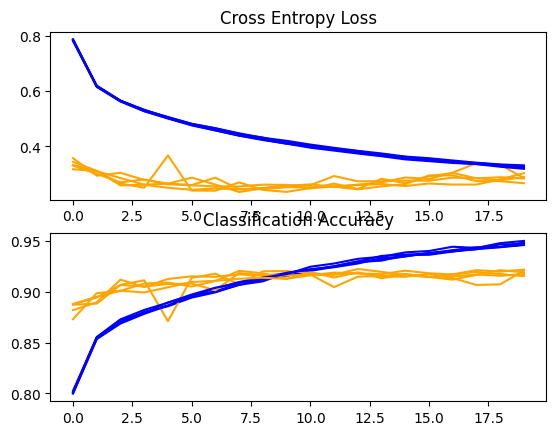

Accuracy: mean=91.893 std=0.233, n=5


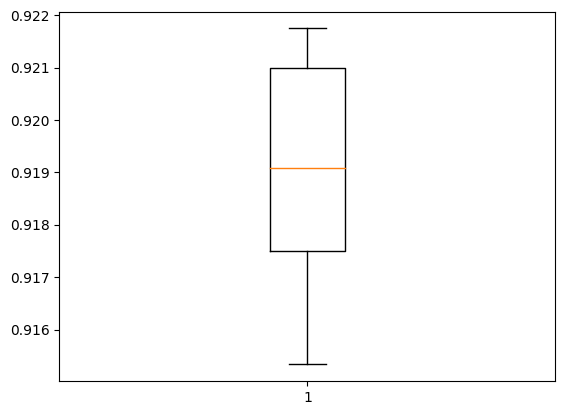

In [21]:

from sklearn.utils import shuffle
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping




# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    # Add the alpha value for MixUp augmentation
    alpha = 0.2

    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # Apply MixUp augmentation to the training data
        trainX, trainY = mixup_data(trainX, trainY, alpha)

        # fit model
        history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

    return scores, histories

# entry point, run the test harness
run_test_harness()

## 8.4 1 DCN+2 Conv

> 91.683
> 91.475
> 91.358
> 91.233
> 91.058


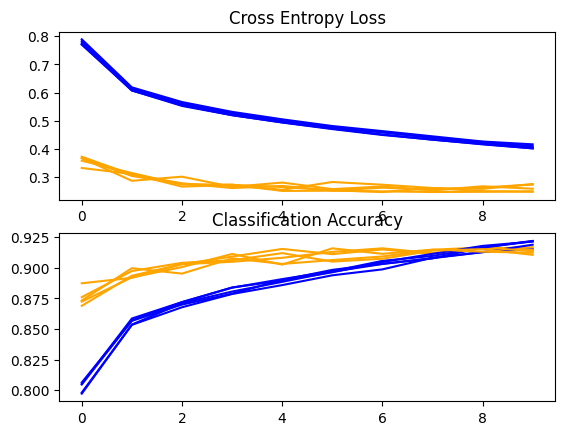

Accuracy: mean=91.362 std=0.212, n=5


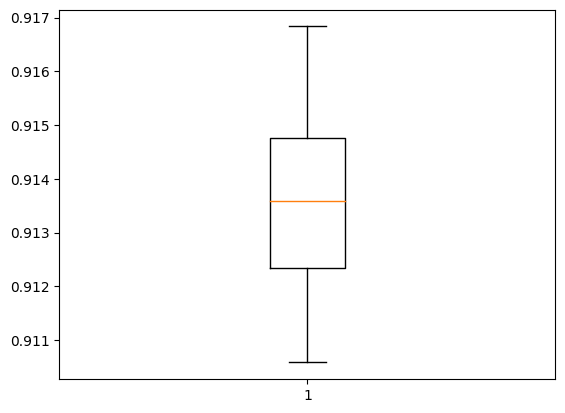

In [22]:

from sklearn.utils import shuffle
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


# define cnn model
def define_model():
    model = tf.keras.Sequential()
    model.add(SimpleDeformableConvLayer(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    # Add the alpha value for MixUp augmentation
    alpha = 0.2

    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # Apply MixUp augmentation to the training data
        trainX, trainY = mixup_data(trainX, trainY, alpha)

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

    return scores, histories


# entry point, run the test harness
run_test_harness()

## 8.5 1 DCN+ 3 Conv

> 91.858
> 91.717
> 91.967
> 91.283
> 92.658


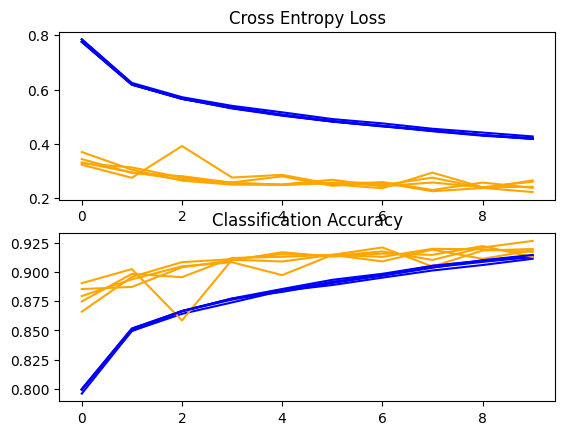

Accuracy: mean=91.897 std=0.446, n=5


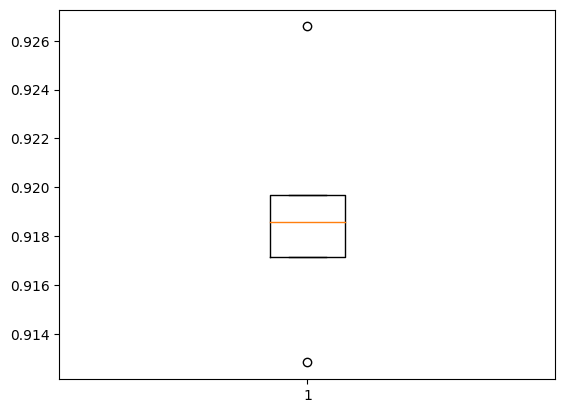

In [23]:
def define_model():
    model = Sequential()
    model.add(SimpleDeformableConvLayer(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))  # Additional convolutional layer
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    # Add the alpha value for MixUp augmentation
    alpha = 0.2

    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # Apply MixUp augmentation to the training data
        trainX, trainY = mixup_data(trainX, trainY, alpha)

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

    return scores, histories


# entry point, run the test harness
run_test_harness()

## 8.6 Data before and after mixup

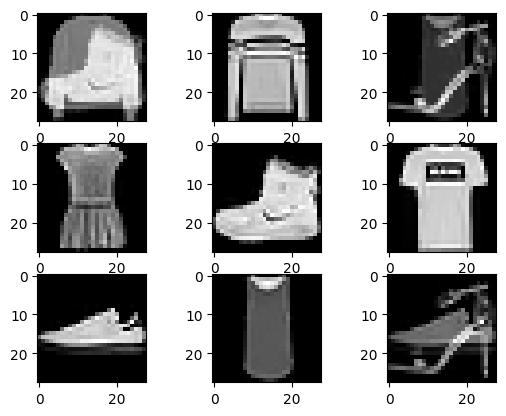

In [ ]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np
from matplotlib import pyplot

# Mixup augmentation function
def mixup_augmentation(X, y, alpha=0.2):
    m = X.shape[0]
    lam = np.random.beta(alpha, alpha, m)
    index = np.random.permutation(m)
    mixed_X = lam.reshape(-1, 1, 1) * X + (1 - lam).reshape(-1, 1, 1) * X[index]
    mixed_y = lam.reshape(-1, 1) * y + (1 - lam).reshape(-1, 1) * y[index]
    return mixed_X, mixed_y

# load dataset
(trainX, trainY), (testX, testy) = fashion_mnist.load_data()
trainY = to_categorical(trainY, 10)  # Ensure one-hot encoding

# Apply mixup augmentation to the first 9 images
augmented_images, augmented_labels = mixup_augmentation(trainX[:9], trainY[:9])

# plot the first 9 augmented images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot augmented image
    pyplot.imshow(augmented_images[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()



4422102/4422102 [==============================] - 0s 0us/step


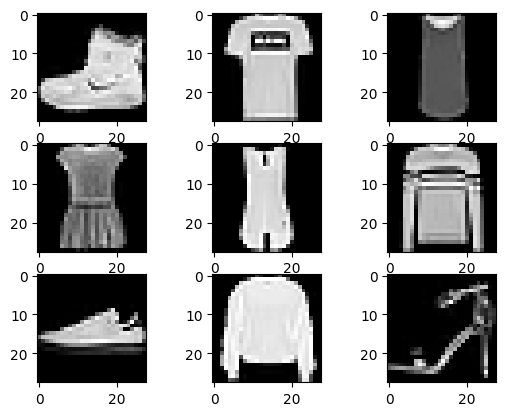

In [ ]:

from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import numpy as np
from sklearn.utils import shuffle

# load dataset
(trainX, trainY), (testX, testy) = fashion_mnist.load_data()trainY = to_categorical(trainY)

# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

# Final model

We have decided to go with the 2 CN(64,128) with mixup

In [28]:
# 2 CN (with padding and 64 and 128 filters) + Pooling with MixUp
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import numpy as np
from sklearn.utils import shuffle

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    # Shuffle the training data
    trainX, trainY = shuffle(trainX, trainY, random_state=42)

    return trainX, trainY, testX, testY


# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def mixup_data(data, labels, alpha=0.2):
    num_samples, num_classes = labels.shape
    l = np.random.beta(alpha, alpha, num_samples)
    l = np.maximum(l, 1 - l)
    X_l = l[:, np.newaxis, np.newaxis, np.newaxis]
    y_l = l[:, np.newaxis]

    # Perform MixUp
    mixed_data = X_l * data + (1 - X_l) * data[::-1]
    mixed_labels = y_l * labels + (1 - y_l) * labels[::-1]

    return mixed_data, mixed_labels

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
 # load dataset
 trainX, trainY, testX, testY = load_dataset()
 # prepare pixel data
 trainX, testX = prep_pixels(trainX, testX)
 # define model
 model = define_model()
 # fit model
 model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
 # save model
 model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.png')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    result = model.predict(img)
    final_result = np.argmax(result)
    print(final_result)

# entry point, run the example
run_example()

1/1 [==============================] - 0s 151ms/step
2
